In [1]:
using ControlSystems, LinearAlgebra, Kronecker, SparseArrays, Plots

# Compile command
run(`gcc EIQP_j.c -o EIQP.so -O3 -lblas -llapack -llapacke -shared -fPIC`)

# define the interface call
const EIQP_lib = "./EIQP.so"
function call_EIQP(Q::Array{Float64,2},c::Array{Float64,1},A::Array{Float64,2},b::Array{Float64,1},epsilon::Float64)
    nc = length(c)
    nb = length(b)
    z = Array{Float64,1}(undef,nc)
    status = ""
    ccall(
        (:EIQP, EIQP_lib),
        Cvoid,
        (Ptr{Cdouble},Ptr{Cdouble},Ptr{Cdouble},Ptr{Cdouble},Cdouble,Cint,Cint,Ptr{Cdouble},Cstring),
        Q,c,A,b,epsilon,nc,nb,z,status
    )
    return z,status
end


call_EIQP (generic function with 1 method)

In [5]:
Ts = 0.05
NSim = 200
Np = 5

# Define the continuous-time model
Ac = [-0.0151 -60.5651 0 -32.174;
      -0.0001 -1.3411 0.9929 0;
      0.00018 43.2541 -0.86939 0;
      0 0 1 0]
Bc = [-2.516 -13.136;
     -0.1689 -0.2514;
     -17.251 -1.5766;
     0 0];
Cc = [0 1 0 0;
      0 0 0 1];
Dc = [0 0;
      0 0];
sys = ss(Ac,Bc,Cc,Dc)
model = c2d(sys, Ts)
nx, nu = size(model.B)
ny, _ = size(model.C)

# MPC-to-QP condense construction
Wy = 10 * I(ny)
Wdu = 0.1 * I(nu)
u_min = [-25;-25]
u_max = [25; 25]
y_min = [-0.5;-100]
y_max = [0.5; 100]

Ai = model.A
AA = Ai
for i in 2:Np
      Ai = model.A*Ai
      AA = [AA; Ai]
end
AiB = model.B
BB = kron(I(Np),AiB)
for i in 1:Np-1
    AiB = model.A * AiB
    BB += kron(spdiagm(-i=>ones(Np-i)),AiB)
end
QQ = kron(I(Np), model.C'*Wy*model.C)
MM = kron(I(Np),I(nu)) + kron(spdiagm(-1=>ones(Np-1)),-I(nu))
RR = kron(I(Np), Wdu)
Q = BB' * QQ * BB + MM' * RR * MM
Gu = kron(I(Np),model.C)*BB
Gx = kron(I(Np),model.C)*AA;

In [6]:
# closed-loop simulation
ref = [0.0; 10.0]
x = [0; 0; 0; 0]
u = zeros(nu)
Ref_Hist = ref
U_Hist = Matrix{Float64}(undef, 2, 0)
Y_Hist = model.C*x
for k in 1:NSim
    if mod(k,100)==0
        ref = [0.0; 0.0]
    end
    Ref_Hist = [Ref_Hist ref]
    # finish uncompleted MPC-to-QP condense construction
    gi = model.A*x
    gg = gi
    fi = -u
    ff = fi
    for i in 2:Np
        gi = model.A*gi
        gg = [gg; gi]
        fi = zeros(nu)
        ff = [ff; fi]
    end
    c = BB' * (QQ*gg - vec(repeat(model.C'*Wy*ref, Np, 1))) + MM' * RR * ff
    lb = vec(repeat(u_min,Np,1))
    ub = vec(repeat(u_max,Np,1))
    Glb = vec(repeat(y_min,Np,1))-Gx*x
    Gub = vec(repeat(y_max,Np,1))-Gx*x
    G = [Gu;-Gu]
    g = [Gub;-Glb]
    c_bar = Q*lb+c
    G_bar = [G; I(Np*nu)]
    g_bar = [g-G*lb;ub-lb]

    # using EIQP solver
    epsilon = 1e-8
    sol, status = call_EIQP(Q, c_bar, -G_bar, -g_bar, epsilon)
    U = sol + lb

    # apply the first control input
    u = U[1:nu]
    x = model.A * x + model.B * u
    U_Hist = hcat(U_Hist, u)
    Y_Hist = [Y_Hist model.C*x]
end

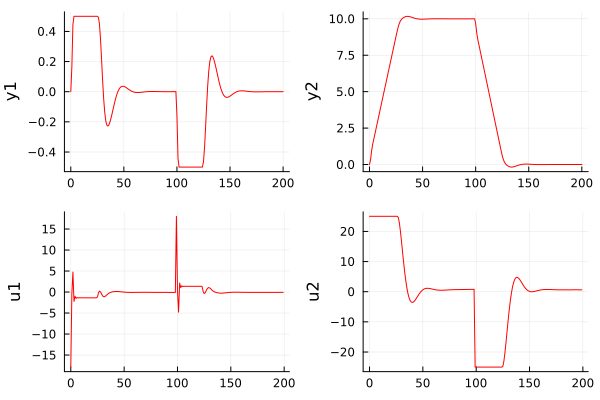

In [7]:
plot_layout = @layout [a b; c d]
p = plot(layout = plot_layout)
plot!(p, 0:NSim, Y_Hist[1,:], label=false, color=:red, linewidth=1,ylabel="y1",subplot=1)
plot!(p, 0:NSim, Y_Hist[2,:], label=false, color=:red, linewidth=1,ylabel="y2",subplot=2)
plot!(p, 0:NSim-1, U_Hist[1,:], label=false, color=:red, linewidth=1,ylabel="u1",subplot=3)
plot!(p, 0:NSim-1, U_Hist[2,:], label=false, color=:red, linewidth=1,ylabel="u2",subplot=4)
